<a href="https://colab.research.google.com/github/suna0107/ANN_DL101/blob/main/%E2%98%85(250415)_Attention(1)weighted_sum%2Bfc%2Brelu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 예측모델 설계: Attention(1)  덧셈 기반 Attention (weighted sum) + FC+ReLU

-  Attention(1184차원) 입력 → FC + ReLU → 최종 1(해당)/0(비해당) 예측

- Attention 구조 (1) 가중합 구조 , 구조(2) multihead attention

- 가중합 구조: 3개 벡터에 각각 가중치를 곱하고 sum

## 1. 데이터 전처리

🔷 STEP 1. 데이터 불러오기 & 라벨 변환

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score


In [2]:

# 데이터 로드
item_df = pd.read_pickle("/content/item_df_vec.pkl")

# 결측치 대비 처리
item_df['hs_vec_800'] = item_df['hs_vec_800'].apply(lambda x: x if isinstance(x, (list, np.ndarray)) else np.zeros(800))
item_df['label'] = item_df['결과'].map({'해당': 1, '비해당': 0}).astype(int)

# 차원 확인
print("🧩 샘플 수:", len(item_df))
print("📌 item_vec 차원:", len(item_df['item_vec'].iloc[0]))
print("📌 company_vecs 차원:", len(item_df['company_vecs'].iloc[0]))
print("📌 hs_vec_800 차원:", len(item_df['hs_vec_800'].iloc[0]))



🧩 샘플 수: 2804
📌 item_vec 차원: 384
📌 company_vecs 차원: 384
📌 hs_vec_800 차원: 800


In [3]:
# 3. Dataset 정의
class MultiInputDataset(Dataset):
    def __init__(self, df):
        self.item_vec = torch.tensor(np.stack(df['item_vec'].values), dtype=torch.float32)
        self.comp_vec = torch.tensor(np.stack(df['company_vecs'].values), dtype=torch.float32)
        self.hs_vec = torch.tensor(np.stack(df['hs_vec_800'].values), dtype=torch.float32)
        self.labels = torch.tensor(df['label'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.item_vec[idx], self.comp_vec[idx], self.hs_vec[idx], self.labels[idx]

# 4. 확인
dataset = MultiInputDataset(item_df)
print("🧩 샘플 수:", len(dataset))
print("📐 item_vec:", dataset[0][0].shape)
print("📐 company_vec:", dataset[0][1].shape)
print("📐 hs_vec:", dataset[0][2].shape)
print("🎯 label:", dataset[0][3])

🧩 샘플 수: 2804
📐 item_vec: torch.Size([384])
📐 company_vec: torch.Size([384])
📐 hs_vec: torch.Size([800])
🎯 label: tensor(0.)


🔷 STEP 3. Train / Validation / Test 분리 (Multi-Input용)

In [4]:
from sklearn.model_selection import train_test_split

# 1. 개별 벡터 추출
item_vecs = np.stack(item_df['item_vec'].values)
comp_vecs = np.stack(item_df['company_vecs'].values)
hs_vecs   = np.stack(item_df['hs_vec_800'].values)
labels    = item_df['label'].values

# 2. 전체 → train+val / test 분리 (test = 20%)
item_item_temp, item_item_test, \
comp_temp, comp_test, \
hs_temp, hs_test, \
y_temp, y_test = train_test_split(
    item_vecs, comp_vecs, hs_vecs, labels,
    test_size=0.2, stratify=labels, random_state=42
)

# 3. train+val → train / val 분리 (val = 20% of 80% = 16%)
item_item_train, item_item_val, \
comp_train, comp_val, \
hs_train, hs_val, \
y_train, y_val = train_test_split(
    item_item_temp, comp_temp, hs_temp, y_temp,
    test_size=0.2, stratify=y_temp, random_state=42
)


- 결과 shape 확인 (선택)

In [5]:
print("🟢 Train:", item_item_train.shape)
print("🟡 Val:  ", item_item_val.shape)
print("🔵 Test: ", item_item_test.shape)

🟢 Train: (1794, 384)
🟡 Val:   (449, 384)
🔵 Test:  (561, 384)


## 2. Dataset 정의 및 dataload

- PyTorch에서는 Dataset정의해야  DataLoader가 미니배치 단위로 꺼낼 수 있음
- 학습용, 검증용, 테스트용 데이터를 PyTorch에서 사용할 수 있도록 구성하는 과정

🔷 STEP 4. TensorDataset & DataLoader 생성

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 텐서 변환
def to_tensor(x): return torch.tensor(x, dtype=torch.float32)

# 각각 텐서 변환
item_item_train = to_tensor(item_item_train)
comp_train = to_tensor(comp_train)
hs_train   = to_tensor(hs_train)
y_train    = to_tensor(y_train).unsqueeze(1)

item_item_val = to_tensor(item_item_val)
comp_val = to_tensor(comp_val)
hs_val   = to_tensor(hs_val)
y_val    = to_tensor(y_val).unsqueeze(1)

item_item_test = to_tensor(item_item_test)
comp_test = to_tensor(comp_test)
hs_test   = to_tensor(hs_test)
y_test    = to_tensor(y_test).unsqueeze(1)

# TensorDataset: 각각 구성 요소를 tuple로 묶기
train_dataset = TensorDataset(item_item_train, comp_train, hs_train, y_train)
val_dataset   = TensorDataset(item_item_val, comp_val, hs_val, y_val)
test_dataset  = TensorDataset(item_item_test, comp_test, hs_test, y_test)

# DataLoader: 배치 처리용
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # shuffle=True : 매 epoch마다 데이터 순서를 랜덤으로 바꿔서 일반화 성능 향상
val_loader   = DataLoader(val_dataset, batch_size=64)
test_loader  = DataLoader(test_dataset, batch_size=64) # test는 예측만 하므로 shuffle=False로 놔도 됨


In [7]:
# 결과 확인
print(f"✅ 학습 배치 수: {len(train_loader)}")
print(f"✅ 검증 배치 수: {len(val_loader)}")
print(f"✅ 테스트 배치 수: {len(test_loader)}")

✅ 학습 배치 수: 29
✅ 검증 배치 수: 8
✅ 테스트 배치 수: 9


## 3. Attention 구조 정의

-  item_vec (384차원), company_vecs (384차원), hs_vec_800 (800차원)

- 이 세 가지를 attention을 통해 가중 합

🔷 STEP 5. Attention 기반 예측 모델 정의

In [8]:
# ✅ 1. Attention 구조 정의 (덧셈 기반, BCEWithLogitsLoss 사용)
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdditiveAttentionClassifier(nn.Module):
    def __init__(self, item_dim=384, company_dim=384, hs_dim=800, hidden_dim=128):
        super().__init__()
        self.proj_company = nn.Linear(company_dim, item_dim)
        self.proj_hs = nn.Linear(hs_dim, item_dim)

        self.classifier = nn.Sequential(
            nn.Linear(item_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1)  # ✅ Sigmoid 없음
        )

    def forward(self, item_vec, company_vec, hs_vec):
        company_vec = self.proj_company(company_vec)
        hs_vec = self.proj_hs(hs_vec)

        concat = torch.stack([item_vec, company_vec, hs_vec], dim=1)
        weights = torch.softmax(concat.mean(dim=2), dim=1)
        weighted_sum = (concat * weights.unsqueeze(2)).sum(dim=1)

        return self.classifier(weighted_sum)  # logits 출력

## 4. 예측 모델 학습 및 검증

1. 손실함수, 옵티마이저, 스케줄러 정의 (pos_weight 적용)

In [9]:
# ✅ 디바이스 설정
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score

counter = Counter(y_train.numpy().flatten())
neg, pos = counter[0], counter[1]
pos_weight = torch.tensor(neg / pos, dtype=torch.float32).to(device)

model = AdditiveAttentionClassifier().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

2. 학습 및 평가 함수 정의


In [11]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for item_vec, comp_vec, hs_vec, y in loader:
        item_vec, comp_vec, hs_vec, y = item_vec.to(device), comp_vec.to(device), hs_vec.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(item_vec, comp_vec, hs_vec)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for item_vec, comp_vec, hs_vec, y in loader:
            item_vec, comp_vec, hs_vec, y = item_vec.to(device), comp_vec.to(device), hs_vec.to(device), y.to(device)
            logits = model(item_vec, comp_vec, hs_vec)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return f1_score(all_labels, all_preds), accuracy_score(all_labels, all_preds)



3. 학습 루프

In [12]:
best_f1 = 0
patience = 3
counter = 0

for epoch in range(1, 21):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_f1, val_acc = eval_epoch(model, val_loader, device)
    scheduler.step()

    print(f"📘 Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_attention_sum_model.pt")
        print("✅ Best model saved.")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("⛔ Early stopping triggered!")
            break


📘 Epoch 01 | Train Loss: 1.1902 | Val Acc: 0.8575 | F1: 0.3191
✅ Best model saved.
📘 Epoch 02 | Train Loss: 1.1409 | Val Acc: 0.7483 | F1: 0.4264
✅ Best model saved.
📘 Epoch 03 | Train Loss: 1.0844 | Val Acc: 0.7706 | F1: 0.4432
✅ Best model saved.
📘 Epoch 04 | Train Loss: 0.9949 | Val Acc: 0.7483 | F1: 0.4264
📘 Epoch 05 | Train Loss: 0.9087 | Val Acc: 0.6993 | F1: 0.3946
📘 Epoch 06 | Train Loss: 0.8345 | Val Acc: 0.7906 | F1: 0.4659
✅ Best model saved.
📘 Epoch 07 | Train Loss: 0.8422 | Val Acc: 0.7194 | F1: 0.4112
📘 Epoch 08 | Train Loss: 0.7800 | Val Acc: 0.7795 | F1: 0.4590
📘 Epoch 09 | Train Loss: 0.7525 | Val Acc: 0.7639 | F1: 0.4421
⛔ Early stopping triggered!


##5. 테스트 데이터 평가

In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. 모델 초기화 및 weight 로드
model = AdditiveAttentionClassifier().to(device)
model.load_state_dict(torch.load("best_attention_sum_model.pt", map_location=device))
model.eval()

# 2. 테스트셋 평가
all_preds, all_labels = [], []

with torch.no_grad():
    for item_vec, comp_vec, hs_vec, y in test_loader:
        item_vec = item_vec.to(device)
        comp_vec = comp_vec.to(device)
        hs_vec = hs_vec.to(device)
        y = y.to(device)

        logits = model(item_vec, comp_vec, hs_vec)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 3. 지표 계산
import numpy as np
y_true = np.array(all_labels).astype(int)
y_pred = np.array(all_preds).astype(int)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# 4. 결과 출력
print("\n📊 [Test Set Evaluation]")
print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall   : {rec:.4f}")
print(f"✅ F1 Score : {f1:.4f}")
print(f"📌 Confusion Matrix:\n{cm}")



📊 [Test Set Evaluation]
✅ Accuracy : 0.7950
✅ Precision: 0.3418
✅ Recall   : 0.8308
✅ F1 Score : 0.4843
📌 Confusion Matrix:
[[392 104]
 [ 11  54]]


##6. 성능향상 위한 최적 threshold 찾기

- 결과 : 0.5로 나옴


🔧 최적 Threshold: 0.60 | F1 Score: 0.5269
✅ 최종 평가 결과 @ Threshold 0.60
Accuracy : 0.8592
Precision: 0.4314
Recall   : 0.6769
F1 Score : 0.5269
📊 Confusion Matrix:
[[438  58]
 [ 21  44]]


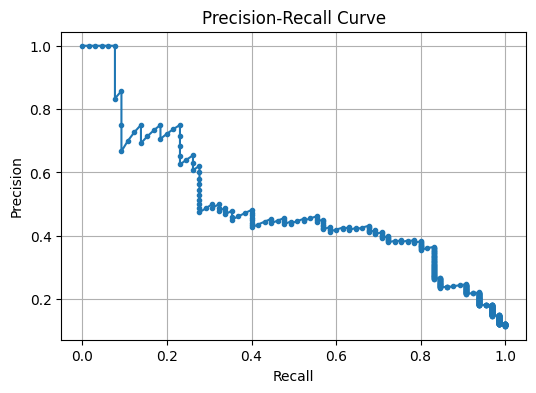

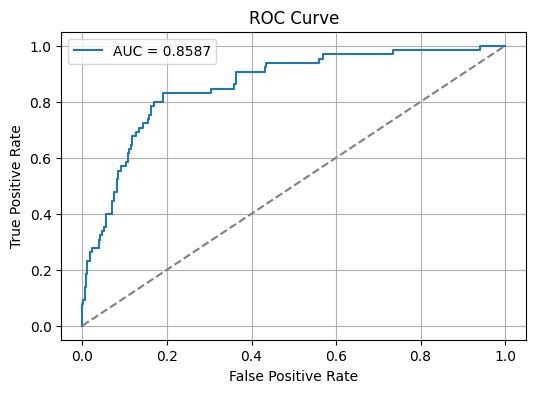

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    precision_recall_curve, roc_curve, roc_auc_score
)

# 1. 예측 확률 수집
model.load_state_dict(torch.load("best_attention_sum_model.pt", map_location=device))
model.eval()

all_probs, all_labels = [], []
with torch.no_grad():
    for item_vec, comp_vec, hs_vec, y in test_loader:
        item_vec = item_vec.to(device)
        comp_vec = comp_vec.to(device)
        hs_vec = hs_vec.to(device)

        logits = model(item_vec, comp_vec, hs_vec)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
        all_probs.extend(probs)
        all_labels.extend(y.numpy().flatten())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels).astype(int)

# 2. Threshold 조정 (0.1 ~ 0.9) → 최적 F1 찾기
thresholds = np.arange(0.1, 0.91, 0.01)
best_f1 = 0
best_thres = 0.5

for th in thresholds:
    preds = (all_probs >= th).astype(int)
    f1 = f1_score(all_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thres = th

print(f"\n🔧 최적 Threshold: {best_thres:.2f} | F1 Score: {best_f1:.4f}")

# 3. 최적 threshold 기준 성능 출력
final_preds = (all_probs >= best_thres).astype(int)

from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(all_labels, final_preds)
prec = precision_score(all_labels, final_preds)
rec = recall_score(all_labels, final_preds)
f1 = f1_score(all_labels, final_preds)
cm = confusion_matrix(all_labels, final_preds)

print(f"✅ 최종 평가 결과 @ Threshold {best_thres:.2f}")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"📊 Confusion Matrix:\n{cm}")

# 4. PR Curve
prec_vals, rec_vals, _ = precision_recall_curve(all_labels, all_probs)
plt.figure(figsize=(6, 4))
plt.plot(rec_vals, prec_vals, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# 5. ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


## 7. Attention 구조(1) 성능 최적화 : 학습증가

-  patience=5로 먼저 학습→ 이후 학습곡선(train_loss, val_f1, val_acc)을 시각화

1. 학습 루프: 기록 저장 포함 (train_losses, val_f1s, val_accs)

In [16]:
train_losses, val_f1s, val_accs = [], [], []
best_f1 = 0
patience = 5
counter = 0

for epoch in range(1, 21):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_f1, val_acc = eval_epoch(model, val_loader, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_f1s.append(val_f1)
    val_accs.append(val_acc)

    print(f"📘 Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_attention_sum_model.pt")
        print("✅ Best model saved.")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("⛔ Early stopping triggered!")
            break


📘 Epoch 01 | Train Loss: 0.8523 | Val Acc: 0.7906 | F1: 0.4659
✅ Best model saved.
📘 Epoch 02 | Train Loss: 0.8042 | Val Acc: 0.7906 | F1: 0.4659
📘 Epoch 03 | Train Loss: 0.8200 | Val Acc: 0.7906 | F1: 0.4659
📘 Epoch 04 | Train Loss: 0.8347 | Val Acc: 0.7906 | F1: 0.4659
📘 Epoch 05 | Train Loss: 0.9167 | Val Acc: 0.7906 | F1: 0.4659
📘 Epoch 06 | Train Loss: 0.8559 | Val Acc: 0.7906 | F1: 0.4659
⛔ Early stopping triggered!


2. 학습 곡선 시각화

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


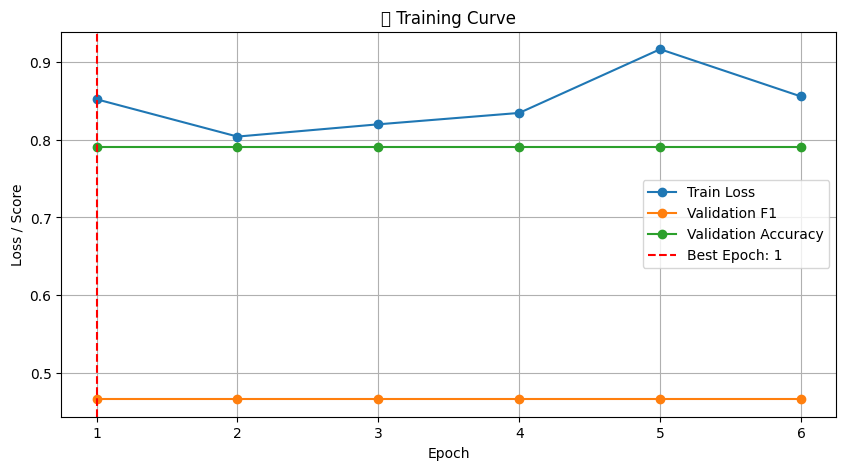

In [17]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(train_losses)+1)
best_epoch = np.argmax(val_f1s) + 1

plt.figure(figsize=(10, 5))

plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_f1s, label='Validation F1', marker='o')
plt.plot(epochs, val_accs, label='Validation Accuracy', marker='o')
plt.axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch: {best_epoch}')
plt.title("📉 Training Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss / Score")
plt.legend()
plt.grid(True)
plt.show()
